In [1]:
import tvm
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tvm.contrib.download import download_testdata
from tvm import relay
from PIL import Image
from tvm.contrib import graph_executor


Get Resnet50 Instance

In [2]:
def resnet50_model():
    model_name = "resnet50"
    model = getattr(torchvision.models, model_name)(pretrained=True)
    model = model.eval()

    input_shape = [1, 3, 224, 224]
    input_data = torch.randn(input_shape)
    scripted_model = torch.jit.trace(model, input_data).eval()
    return model, scripted_model

Get image data ready

In [3]:
def get_original_img():
    img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
    img_path = download_testdata(img_url, "cat.png", module="data")
    img = Image.open(img_path).resize((224, 224))
    plt.imshow(img)
    return img

Image transform

In [4]:
def image_preprocess(img):
    my_preprocess = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )
    img = my_preprocess(img)
    img = np.expand_dims(img, 0)
    return img

In [5]:
def get_parameter(img, scripted_model, activation_bit):
    input_name = "input0"
    shape_list = [(input_name, img.shape)]
    mod, params = relay.frontend.from_pytorch(scripted_model, shape_list)
    with relay.quantize.qconfig(
        global_scale = 8.0, 
        nbit_input = 8,
        nbit_weight=8,
        nbit_activation=activation_bit,
        dtype_input = "int8",
        dtype_weight='int8',
        dtype_activation = 'bool'
    ):
        relay_ir = relay.quantize.quantize(mod, params)
    return relay_ir, params, input_name

In [6]:
def llvm_config(mod, params):
    target = tvm.target.Target("llvm", host="llvm")
    dev = tvm.cpu(0)
    with tvm.transform.PassContext(opt_level=3):
        lib = relay.build(mod, target=target, params=params)
    return lib, dev

In [7]:
def get_output(lib, dev, input_name, img):
    dtype = "float32"
    m = graph_executor.GraphModule(lib["default"](dev))
    m.set_input(input_name, tvm.nd.array(img.astype(dtype)))
    m.run()
    tvm_output = m.get_output(0)
    return tvm_output, m

In [8]:
def get_class_output(tvm_output, img, model):
    synset_url = "".join(
        [
            "https://raw.githubusercontent.com/Cadene/",
            "pretrained-models.pytorch/master/data/",
            "imagenet_synsets.txt",
        ]
    )
    synset_name = "imagenet_synsets.txt"
    synset_path = download_testdata(synset_url, synset_name, module="data")
    with open(synset_path) as f:
        synsets = f.readlines()

    synsets = [x.strip() for x in synsets]
    splits = [line.split(" ") for line in synsets]
    key_to_classname = {spl[0]: " ".join(spl[1:]) for spl in splits}

    class_url = "".join(
        [
            "https://raw.githubusercontent.com/Cadene/",
            "pretrained-models.pytorch/master/data/",
            "imagenet_classes.txt",
        ]
    )
    class_name = "imagenet_classes.txt"
    class_path = download_testdata(class_url, class_name, module="data")
    with open(class_path) as f:
        class_id_to_key = f.readlines()

    class_id_to_key = [x.strip() for x in class_id_to_key]

    # Get top-1 result for TVM
    top1_tvm = np.argmax(tvm_output.numpy()[0])
    tvm_class_key = class_id_to_key[top1_tvm]

    # Convert input to PyTorch variable and get PyTorch result for comparison
    with torch.no_grad():
        torch_img = torch.from_numpy(img)
        output = model(torch_img)

        # Get top-1 result for PyTorch
        top1_torch = np.argmax(output.numpy())
        print(top1_torch)
        torch_class_key = class_id_to_key[top1_torch]

    print("Relay top-1 id: {}, class name: {}".format(top1_tvm, key_to_classname[tvm_class_key]))
    print("Torch top-1 id: {}, class name: {}".format(top1_torch, key_to_classname[torch_class_key]))
    return key_to_classname, class_id_to_key

8 -> 32

/home/simon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/simon/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


282
Relay top-1 id: 650, class name: microphone, mike
Torch top-1 id: 282, class name: tiger cat


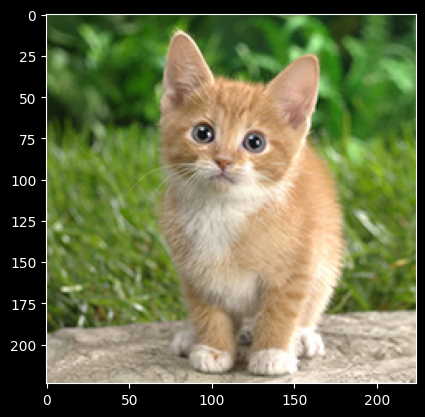

In [9]:
model, scripted_model = resnet50_model()
img = get_original_img()
img = image_preprocess(img)
mod, params, input_name = get_parameter(img, scripted_model, 1)
lib, dev = llvm_config(mod, params)
tvm_output, m = get_output(lib, dev, input_name, img)
_, _ = get_class_output(tvm_output, img, model)

In [10]:
print(lib.get_lib().get_source("ll"))

; ModuleID = 'TVMMod'
source_filename = "TVMMod"
target datalayout = "e-m:e-p270:32:32-p271:32:32-p272:64:64-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

%0 = type { i32*, i32 }
%1 = type { i8*, %2, i32, %3, i64*, i64*, i64 }
%2 = type { i32, i32 }
%3 = type { i8, i8, i16 }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused = type { i8*, i8*, i8* }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused.0 = type { i8*, i8*, i8* }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused.1 = type { i8*, i8*, i8* }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused.2 = type { i8*, i8*, i8* }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused.3 = type { float*, i8* }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused.4 = type { i8*, i8*, i8*, i8* }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused.5 = type { i8*, i8*, i8*, i8* }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused.6 = type { i8*, i8*, i8*, i8* }
%closure_loop_parallel_ax0.ax1.fused.ax2.fused.7 = type { i8*, i8*, i8*, i8* }
%closure_lo

In [11]:
timer = m.module.time_evaluator("run", dev, 20, 3)
timing = np.array(timer().results) * 1000
print(timing.mean())

103.15705806666666
